In [1]:
#default_exp ensemble

In [2]:
#hide
from nbdev.showdoc import *

In [3]:
#hide
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

# Dev comments

Project definitions:

- Set a method called dfit or overwrite fit method in order to have sklearn pipeline support?
- Delegates for an instance of estimator inside class or increment classes through factories (better support in sklearn pipelines)?


- [X] TODO: Solve Tree Predict mistery
- [ ] TODO: make meta bagged randomized prior class
- [X] TODO: make a multivariate joint dist estimator for AdaBoostingRegressor

- [X] TODO: make boosting and baging tree estimator classes
- [X] TODO: implement bagging and boosting meta estimator (include sampling from sub models)
- [X] TODO: include target scaling in pipeline
- [ ] TODO: Create DensityEstimator Base Class containing sample and density methods (density calls sample and returns RV CLASS)
- [ ] TODO: Mean, Variance and Entropy explainer tool (LIME, SHAP, foressts...)
- [X] TODO: Decide wether to allow multi output (doesnt model well multivariate bimodal joint probabilities, cheeky to sample (two different random samples))
- [X] Entropy based regression with random forest embeddings + entropy of targets in each node
- [X] enhance multioutput estimator class
- [X] make possible for user defined sample weights for y_ in self.sample(allow time exponential decay sampling, for example) WE MAY GET THE DISTRIBUTION FOR FREE WITH self.proba_preds

- [X] Make EntropyEstimator class to handle any estimator turning regression problem into a classification one
- [X] fix resolution to any number of bins
- [X] Make EntropyEstimator Ensemble (Bagging and Boosting) - Came for free with BaggingClassifier (predict_proba)
- [ ] Make _ChainedJointEstimator
- [X] Update EntropyEstimator sampling method encompassing KDE sampling
- [ ] Incorporate _ChainedJointEstimator on MultiOutputEntropyEstimator
- [ ] Reorganize 01_ensemble in 01_entropy_estimator, 02_joint_estimator and 03_ensemble_estimator
- [X] Change name of MultiOutputEtimator to JointOutputEstimtor
- [ ] Create KDEEstimator for continuous variables only
- [ ] Make cov_add_noise in estimators

# Imports -

In [510]:
#export
from warnings import warn
from functools import partial
import copy
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
from sklearn import ensemble
from sklearn.base import BaseEstimator
from sklearn.preprocessing import OneHotEncoder, normalize, QuantileTransformer, FunctionTransformer
from sklearn.multioutput import MultiOutputRegressor
from sklearn.utils.fixes import _joblib_parallel_args
from sklearn.metrics import pairwise
from numpy.linalg import LinAlgError
from scipy.spatial.distance import cdist

import scipy
from joblib import Parallel, delayed


from scikit_density.utils import (cos_sim_query, sample_multi_dim, ctqdm, add_noise,sample_from_dist_array,
                                  DelegateEstimatorMixIn, _fix_X_1d, _fix_one_dist_1d, _fix_one_dist_2d,
                                  _add_n_dists_axis,_add_n_samples_axis,_add_n_dims_axis,sample_idxs
                                 )

from scikit_density.metrics import kde_entropy, quantile, marginal_variance, bimodal_variance, kde_likelihood, kde_quantile, agg_smallest_distance
from scikit_density.core.random_variable import KDE

# Ensemble density estimators -

Density estimators based on ensemble methods, such as baging, boosting and some decision tree algorithms. All 'classes' are actually factories that dinamically extends the funcitonality of the original sklearn class with methods such as sample.

# Example data

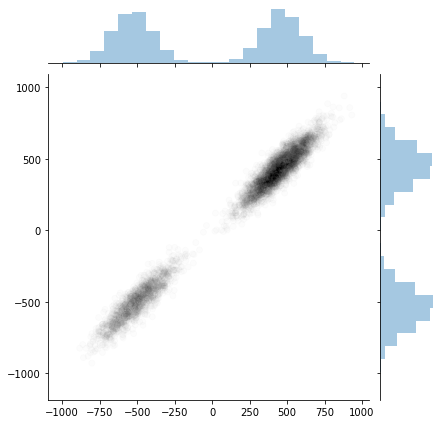

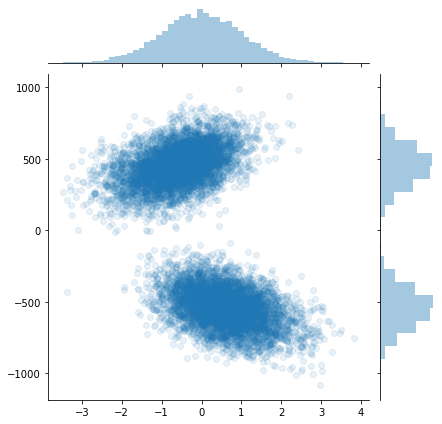

In [5]:
import seaborn as sns
from sklearn.datasets import make_regression
from matplotlib import cm

def sigmoid(x):
    return 1/(1+np.exp(x))

X,y = make_regression(
    n_samples=10000,
    n_features=15,
    n_informative=6,
    n_targets=2,
    bias=500,
    effective_rank=None,
    tail_strength=5,
    noise=1,
    shuffle=True,
    coef=False,
    random_state=None
)


#make one of X[1] feature mode weightening
bimodal_factor_wieght = 2
bimodal_factors = (sigmoid(bimodal_factor_wieght*X[:,-1]) > np.random.random(size = X.shape[0])).astype(int)
bimodal_factors[bimodal_factors == 0] = -1
bimodal_factors = bimodal_factors.reshape(-1,1)

y = bimodal_factors*y

colors = cm.get_cmap('binary')(256*(sigmoid(bimodal_factor_wieght*X[:,-1]) > np.random.random(size = X.shape[0])).astype(int))

sns.jointplot(y[:,0],y[:,1], joint_kws = {'color': colors}, alpha = 0.01)

sns.jointplot(X[:,-1], y[:,1], alpha = 0.1)

X_train, X_test = X[:int(0.8*len(X))], X[int(0.8*len(X)):]
y_train, y_test = y[:int(0.8*len(X))], y[int(0.8*len(X)):]

# MultiOutputRegressor (Move to skdensity.meta and fix sampling problem)

In [695]:
#export
class JointEstimator(MultiOutputRegressor):
    '''Custom multioutput for multioutput cases except random forests (which handles multi output directly)'''
    def apply(self,X):
        result = [estim.apply(X) for estim in self.estimators_]
        return np.concatenate(result, axis = -1)
    def sample(self, X, sample_size = 10, weights = None):        
        result = np.array([estim.sample(X, sample_size = sample_size, weights = weights) for estim in self.estimators_])
        result = np.swapaxes(result,0,1)
        result = np.swapaxes(result,1,2)
        return result
    
class JointEntropyEstimator(MultiOutputRegressor):
    '''Custom multioutput for multioutput cases except random forests (which handles multi output directly)'''
    def apply(self,X):
        result = [estim.apply(X) for estim in self.estimators_]
        return np.concatenate(result, axis = -1)
    def sample(self, X, sample_size = 10, weights = None):        
        result = np.array([estim.sample(X, sample_size = sample_size, weights = weights) for estim in self.estimators_])
        result = np.swapaxes(result,0,1)
        result = np.swapaxes(result,1,2)
        return result
    
class JointSimilarityTreeEstimator(MultiOutputRegressor):
    '''Custom multioutput for multioutput estimator for `SimilarityTreesEstiamtor`s'''    
    @property
    def y_(self,):
        '''stacked y_ attributes of each estimator (one for each dim)'''
        return np.hstack([_fix_X_1d(estim.y_) for estim in self.estimators_])

    def _similarity_sample_idx(self, X, sample_size = 100, weights = None, n_neighbors = 10,
                           lower_bound = 0.0, alpha = 1, beta = 0, gamma = 0):
        
        sampled_idxs = np.hstack([
            _fix_X_1d(estim._similarity_sample_idx(X, sample_size, weights, n_neighbors,
                           lower_bound, alpha, beta, gamma)
            ) for estim in self.estimators_
        ])
        
        return sampled_idxs            
    
    def sample(self, X, sample_size = 100, weights = None, n_neighbors = 10,
                           lower_bound = 0.0, alpha = 1, beta = 0, gamma = 0, noise_factor = 1e-3):        
        
        idxs = self._similarity_sample_idx(
            X, sample_size, weights, n_neighbors,lower_bound, alpha, beta, gamma)
                
        samples = self.y_[[idx for idx in idxs]]
        #fix ndim if sampling for a single value (1, n_samples, n_dims) instead of (n_samples, n_dims)
        samples = samples if len(samples.shape) != 2 else _add_n_dists_axis(samples)
        # samples will have n_dims*sample_size samples, resample with no replacement to match sample_size
        samples = sample_from_dist_array(samples, sample_size = sample_size, weights = None, replace = False)
        return add_noise(samples, noise_factor)
    
    def custom_predict(self, X, agg_func, sample_size = 100, weights = None, n_neighbors = 10,
                           lower_bound = 0.0, alpha = 1, beta = 0, gamma = 0):
        
        samples = self.sample(X, sample_size = 100, weights = None, n_neighbors = 10,
                           lower_bound = 0.0, alpha = 1, beta = 0, gamma = 0)
        
        return np.array([agg_func(sample) for sample in samples])
        

# EntropyEstimator
> An estimator that performas a classification on a discretized transformation of a continuous space using QuantileTransformer, predicts a probability distribution using proba_preds and maps back to continuous domain.
Base estimator can be any estimator that performs predict_proba method.

In [696]:
#export
class EntropyEstimator(BaseEstimator, DelegateEstimatorMixIn):
    '''
    Meanwhile only performs marginal density estiamtion, not joint. Thus, only 1dimensional y.
    For joint, should try something using RegressionChain (to pass dimension information to the prediction of other dims)
    '''
    def __init__(self,estimator, resolution = 200, alpha = 1, bins_dist_kws = {} ,**q_transformer_kws):
        assert hasattr(estimator, 'predict_proba'), 'estimator should have `predict_proba` method'
        self.estimator = estimator
        self.q_transformer = QuantileTransformer(**q_transformer_kws) #<-- pass object as argument??
        self.alpha = alpha
        self.resolution = resolution
        self.bins_dist_kws = bins_dist_kws
        return
    
    def _q_transformer_fit(self, y):
        '''
        fits self.q_transformer
        '''
        y = _fix_X_1d(y)
        self.q_transformer.fit(y)
        return self.q_transformer
    
    def _q_transformer_transform(self, y):
        '''
        maps floats to int (bin_id in histogram)
        '''
        y = _fix_X_1d(y)
        y_transformed = self.q_transformer.transform(y)
        y_transformed = np.around(y_transformed*(self.resolution - 1), decimals = 0).astype(int)
        return y_transformed.flatten()
    
    def _q_transformer_inverse_transform(self,y):
        '''
        maps from bin_id in histogram (int) to float.
        beware that during transform, information is lost due to downsampling, so inverse_transform will
        not be an exact inverse_transform.        
        '''
        y = _fix_X_1d(y)
        y_transformed = (y/(self.resolution - 1)).astype(float)        
        return self.q_transformer.inverse_transform(y_transformed).flatten() #1d asserted already
        
    def fit(self, X, y = None, **estimator_fit_kws):        
        #set y_dim
        if len(y.shape) == 1:
            self.y_dim = 1
        elif len(y.shape) == 2:
            # assert 1d
            assert self.y_dim[-1] == 1, 'y should be 1d. For joint estimation use JointOutputEstimator'
            self.y_dim = y.shape[-1]
        else:
            raise AssertionError('y should be 1d vector or 2d column array (n_samples,1)')
        #reshape when y.dim == 1 and array dim equals 2
        if self.y_dim == 1:
            y = y.reshape(y.shape[0])
                
        self._q_transformer_fit(y)
        # Fit one instance of RandomVariable or KDE for each bin:
        y_transformed = self._q_transformer_transform(y)
        bin_ids = list(set(y_transformed))
        bins_data_mapper = [y[y_transformed == i] for i in bin_ids]
        self._bin_dist_estimators = [KDE(**self.bins_dist_kws).fit(d) for d in bins_data_mapper]
        #fit classifier
        self.estimator.fit(X = X, y = y_transformed, **estimator_fit_kws)
        return self
        
    def _get_bin_pdf(self,X):
        '''
        returns pdf array of shape (n_dists, n_bins, n_dims)
        the values are the probability "density" for that bin
        '''
        probas = self.estimator.predict_proba(X)        
        probas = np.array(probas)
        return probas
    
    def custom_predict(self, X):
        pass
    
    def _rv_bin_sample(self, bin_probas, sample_size):
        '''
        Generate RV samples from bins of 1 observation
        '''
        assert len(bin_probas.shape) == 2, f'Passed weights array should be 2d not {bin_probas.shape}'
        #sample_sizes = np.round(sample_size*weights_array,0)
        #delta_sample_sizes = sample_size - sample_sizes.sum(axis = 0)
        # make sample_sizes sum up to sample_size <- there might be a better way to do it
        #assert delta_sample_sizes >= 0, 'sample_size sanity check not passed, delta negative'
        #if delta_sample_sizes > 0:
        #    idxs = sample_idxs(weights_array, sample_size = delta_sample_sizes)
        #    idxs, counts = numpy.unique(a, return_counts=True)
        #    for i in range(idxs.shape[0]):
        #        sample_sizes[idxs[i]] += counts[i]
        #SAMPLE ALL KDES AND THE SAMPLE FROM SAMPLED ARRAY
        samples_kde = np.array([bin_dist.sample(sample_size) for bin_dist in self._bin_dist_estimators])                    
        samples_kde = samples_kde[:,:,0]
        idxs = sample_idxs(bin_probas, sample_size = sample_size)
        samples = []
        
        for i in tqdm([*range(bin_probas.shape[0])]):            
            idx = idxs[i]
            idx, counts = np.unique(idx, return_counts = True)
            
            s = [np.random.choice(samples_kde[i],c, replace = True) for i,c in zip(idx,counts)]
            #s = [self._bin_dist_estimators[vc[0]].rvs(sample_size = vc[1]).flatten() for vc in value_counts]
            samples.append(np.concatenate(s))
            #samples.append(np.concatenate(s))
        return np.array(samples)
        
    def sample(self, X, sample_size = 100, weight_func = None, alpha = None, replace = True, noise_factor = 1e-3):
        '''
        weight func is a function that takes weight array (n_dists, n_bins) and returned
        an array of the same shape but with desired processing of the weights. if weight_func is not None,
        alpha is ignored
        ''' 
        #set alpha if not None, else use self.alpha
        alpha = alpha if not alpha is None else self.alpha
        
        #apply weight_func if not None, else, power to alpha
        bins_probas = self._get_bin_pdf(X)
        
        if self.y_dim == 1:
            bins_probas = _add_n_dists_axis(bins_probas)
        
        bins_probas = _fix_X_1d(bins_probas)
        # for 1d case
        bins_probas = bins_probas[0,:,:]
        if not weight_func is None:            
            bins_probas = normalize(weight_func(bins_probas), norm  = 'l1')
        else:
            bins_probas = normalize(bins_probas**alpha, norm = 'l1')
        
        #samples = []
        #for dim_dist in bins_probas:
        #    dim_dist = _fix_X_1d(dim_dist)
        #    if not weight_func is None:            
        #        bin_probas = normalize(weight_func(dim_dist), norm  = 'l1')
        #    else:
        #        bin_probas = normalize(dim_dist**alpha, norm = 'l1')

        #    sampled_bins = sample_idxs(bin_probas, sample_size, replace)                
            #reshape in order to work with the QuantileTransformer inverse_transform foe each iteration
            #sampled_bins = sampled_bins.reshape(*sampled_bins.shape, 1)
            #samples.append(sampled_bins)
        
        #samples = np.array([self._q_transformer_inverse_transform(sb) for sb in samples])
        #samples = np.array(samples)
        #samples = np.moveaxis(samples, 2,1)
        #samples = np.moveaxis(samples, 0,2)

        #samples = np.array([self._q_transformer_inverse_transform(s) for s in samples])
        samples = self._rv_bin_sample(bins_probas, sample_size)
        samples = _add_n_dims_axis(samples) # make a 3d sample array with dim axis = 1
        return add_noise(samples, noise_factor)
        
    def score(self, X, y = None, **score_kws):
        return self.estimator.score(X, self._q_transformer_transform(y), **score_kws)
        

`EntropyEstimator` turns the regression problem into a classification one, predicts the expected bins and the turns it back to continuous domain.
It accepts any estimator with the `predict_proba` method as a base estimator.

It works well for any kind of distribution, but only supports marginal distribution estimation

In [697]:
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

estim1 = EntropyEstimator(LogisticRegression(), 10)
estim2 = EntropyEstimator(ensemble.RandomForestClassifier(), 10)
estim1.fit(X_train, y_train[:,1])
estim2.fit(X_train, y_train[:,1])

EntropyEstimator(estimator=RandomForestClassifier(), resolution=10)

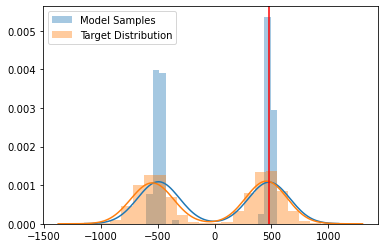

In [698]:
i = 5

alpha, beta, gamma = 1,1,1
samples2 = estim1.sample(X_test[i:i+1], sample_size = 200, alpha = alpha)
#prediction = density_estimator1.custom_predict(
#    X_test[i:i+1], agg_func = lambda x: np.mean(x,axis = 0), alpha = alpha, beta = beta, gamma = gamma)
#naive_prediction = density_estimator1.predict(X_test[i:i+1])

if (len(samples2.shape) > 1) and (samples2.shape[-1] == 2):
    jntplot = sns.jointplot(samples2[0,:,0], samples2[0,:,1], joint_kws = {'label':'Model Samples', 'alpha':0.1})
    jntplot.ax_joint.scatter(y[:,0], y[:,1], color = 'orange', alpha = 0.01, label = 'Target Distribution')
    jntplot.ax_joint.scatter(y_test[i,0], y_test[i,1], color = 'red', label = 'Target Value')
    jntplot.ax_joint.scatter(prediction[0,0], prediction[0,1], color = 'yellow', label = 'Predicted Value')
    jntplot.ax_joint.scatter(naive_prediction[0,0], naive_prediction[0,1], color = 'cyan', label = 'Naive Predicted Value')
      
    jntplot.ax_joint.legend()

else:
    dst = sns.distplot(samples2, kde = True, bins = 20, hist_kws = {'label':'Model Samples'})
    dst = sns.distplot(y_test[:,1], kde = True, bins = 20, hist_kws = {'label':'Target Distribution'})
    dst._axes.axvline(y_test[i,1], color = 'r')
    dst._axes.legend()
    
    

In [699]:
alpha = 1
samples1 = estim1.sample(X_test, 100, alpha = alpha, noise_factor = 1)
samples2 = estim2.sample(X_test, 100, alpha = alpha, noise_factor = 1)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log2
  """Entry point for launching an IPython kernel.


0.08106260324750617 0.0027524436699265563


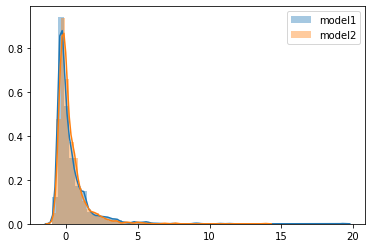

In [700]:
nll1 = -np.log2(kde_likelihood(y_test[:,1:2],samples1))
nll2 = -np.log2(kde_likelihood(y_test[:,1:2],samples2))
sns.distplot(nll1[nll1 < 30], label = 'model1')
sns.distplot(nll2[nll2 < 30], label = 'model2')
plt.legend()
print(np.median(-nll1[nll1 < 1e10]), -np.median(nll2[nll2 < 1e10]))

0.8483106884785753 0.8683277145966519


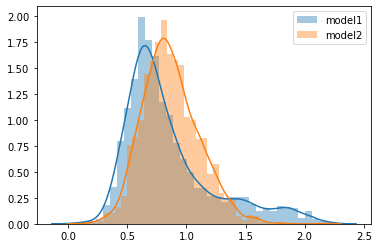

In [701]:
entr1 = kde_entropy(samples1, sample_size = 100)
entr2 = kde_entropy(samples2, sample_size = 100)
sns.distplot(entr1, label = 'model1')
sns.distplot(entr2, label = 'model2')
plt.legend()
print(entr1.mean(),entr2.mean())


In [219]:
q2 = kde_quantile(y_test[:,0],samples2)
q1 = kde_quantile(y_test[:,0],samples1)

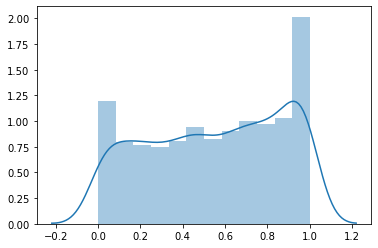

In [220]:
sns.distplot(q1)

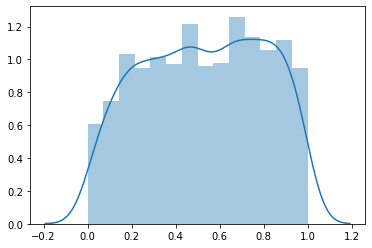

In [221]:
sns.distplot(q2)

# Ensemble Tree methods

## Ensemble tree mixin class
>creates some functionalities for similarity sampling based random forests and naive sampling random forests

In [702]:
#export
#node quality functions
def expected_likelihood(node_data, sample_size = 100):
    kde = KDE().fit(node_data)
    return np.mean(kde.evaluate(kde.rvs(sample_size = sample_size)))

def inverese_log_node_var(node_data):  #makes no sense for multivariate distribtuions  
    centroid = node_data.mean(axis = 0).reshape(1,-1)
    distances =  cdist(node_data, centroid, 'seuclidean').flatten()  
    return 1/np.log1p(np.mean(distances))


# datapoint-node functions
def datapoint_pdf(node_data):
    return KDE().fit(node_data).pdf(node_data)

def datapoint_gaussian_likelihood(node_data):    
    centroid = node_data.mean(axis = 0).reshape(1,-1)
    distances =  cdist(node_data, centroid, 'seuclidean').flatten()  
    distance_std = distances.std()
    #if distance_std == 0:
    #    return 1
    z = (distances - distances.mean())/distance_std
    return 1/(distance_std*np.pi**(1/2))*np.exp(-1/2*z**2)

def _bimodal_variance_fix_dim(x):
    if len(x.shape) == 1:
        return 1/np.log1p(bimodal_variance(_fix_one_dist_1d(x)))
    else:
        return 1/np.log1p(bimodal_variance(_fix_one_dist_2d(x)))
    

AVALIBLE_NODE_AGG_FUNC = {
    'expected_likelihood':expected_likelihood,
    'inverse_log_variance':inverese_log_node_var,
    'inverse_log_bimodal_variance': _bimodal_variance_fix_dim
}

AVALIBLE_DATAPOINT_WEIGHT_FUNC = {
    'kde_likelihood': datapoint_pdf,
    'gaussian_likelihood': datapoint_gaussian_likelihood
}

In [703]:
#export
class EnsembleTreesDensityMixin():    
    
    '''Base Class containing important methods for building Naive and Similarity Density Tree estimators'''
    
    @property
    def _node_data_generator(self):
        return self._make_node_data_generator(self.y_, self._raw_leaf_node_matrix)
    
    def _make_node_kde_array(self): #<- since kde esitmation is the best approach, save kde fitted instances for each node
        #to make use of it during node and node_data wieght inference
        #maybe its better to get data from multiple nodes before fitting kde
        raise NotImplementedError
        
    def _make_node_cdist_array(self): #<- gaussian likelihood works fine as well, so save cdist matrix for each node
        raise NotImplementedError
    
    def _apply(self, X):
        '''
        A substitute for estimator.apply in case it returns 3d arrays (such as sklearns gradient boosting classifier)
        instead of 2d. In case returned array from estimator.apply returns a 2dim array, the returned value of the function
        is the same as the returned array of self.estimator.apply
        '''
        applied_arr = self.estimator.apply(X)
        dim1_shape = applied_arr.shape[0]
        dim2_shape = np.prod(applied_arr.shape[1:])        
        return applied_arr.reshape(dim1_shape, dim2_shape)
    
    def _fit_leaf_node_matrix(self, X, y, node_rank_func, node_data_rank_func):
        nodes_array = self._apply(X)
        encoder = OneHotEncoder()
        leaf_node_matrix = encoder.fit_transform(nodes_array)
          
        self._raw_leaf_node_matrix = leaf_node_matrix
        #self._node_data_generator = self.#self._make_node_data_generator(y, leaf_node_matrix)
        self._leaf_node_weights = self._calculate_node_weights(y, leaf_node_matrix, node_rank_func)
        self._encoder = encoder        
        self._leaf_node_matrix = self._make_weighted_query_space(y, leaf_node_matrix, node_data_rank_func)# <- try making this a property
        return self

    def _transform_query_matrix(self, X):
                
        return  self._make_weighted_query_vector(
            agg_node_weights = self._leaf_node_weights,
            node_matrix = self._encoder.transform(self._apply(X)))
        
    
    def _query_idx_and_sim(self, X, n_neighbors, lower_bound, beta, gamma):        
        idx, sim = cos_sim_query(
            self._transform_query_matrix(X), self._leaf_node_matrix, n_neighbors=n_neighbors,
            lower_bound=lower_bound, beta = beta, gamma = gamma)        
        return idx, sim
    
    
    def _kde_similarity_sample(self, X, sample_size = 100, weights = None, n_neighbors = 10,
                           lower_bound = 0.0, alpha = 1, beta = 0, gamma = 0, noise_factor = 1e-3, **kde_kwargs):
        
        idx, sim = self._query_idx_and_sim(X ,n_neighbors=n_neighbors, lower_bound=lower_bound,beta = beta, gamma = gamma)                
        idx, sim = np.array(idx), np.array(sim)
        
        p = self._handle_sample_weights(weight_func = weights, sim = sim, alpha = alpha)
        samples = []        
        for i in range(len(idx)):            
            ys = self.y_[sample_multi_dim(idx[i], sample_size = sample_size, weights = p[i], axis = 0)]
            noise = agg_smallest_distance(ys.reshape(1,*ys.shape), agg_func = np.std)
            ys = add_noise(ys, noise_factor*noise)
            samples.append(KDE(**kde_kwargs).fit(ys, sample_weight = None).sample(sample_size = sample_size))                                
            #try 
        
        return np.array(samples)
        
    def _similarity_sample(self, X, sample_size = 100, weights = None, n_neighbors = 10,
                           lower_bound = 0.0, alpha = 1, beta = 0, gamma = 0, noise_factor = 1e-3):
        
        idx, sim = self._query_idx_and_sim(X ,n_neighbors=n_neighbors, lower_bound=lower_bound,beta = beta, gamma = gamma)                
        idx, sim = np.array(idx), np.array(sim)
        
        p = self._handle_sample_weights(weight_func = weights, sim = sim, alpha = alpha)        
        samples = []        
        for i in range(len(idx)):            
            ys = self.y_[sample_multi_dim(idx[i], sample_size = sample_size, weights = p[i], axis = 0)]
            noise = agg_smallest_distance(ys.reshape(1,*ys.shape), agg_func = np.std)
            ys = add_noise(ys, noise_factor*noise)            
            samples.append(ys)
                    
        return np.array(samples)
    
    def _similarity_sample_idx(self, X, sample_size = 100, weights = None, n_neighbors = 10,
                           lower_bound = 0.0, alpha = 1, beta = 0, gamma = 0):
        
        idxs, sim = self._query_idx_and_sim(X ,n_neighbors=n_neighbors, lower_bound=lower_bound,beta = beta, gamma = gamma)                
        idxs, sim = np.array(idxs), np.array(sim)
        
        p = self._handle_sample_weights(weight_func = weights, sim = sim, alpha = alpha)        
        
        samples_idxs = sample_from_dist_array(idxs.reshape(*idxs.shape,1), sample_size, p)        
        samples_idxs = samples_idxs.reshape(samples_idxs.shape[:-1])
        return samples_idxs
    
    def _similarity_empirical_pdf(self, X, weights, n_neighbors, lower_bound, alpha, beta, gamma):
        
        idx, sim = cos_sim_query(
            self._transform_query_matrix(X),
            self._leaf_node_matrix,
            n_neighbors=n_neighbors,
            lower_bound=lower_bound,
            beta = beta,
            gamma = gamma)
        p = self._handle_sample_weights(weight_func = weights, sim = sim, alpha = alpha)
        return np.array([self.y_[i] for i in idx]), p
    
    def _custom_predict(self, X, agg_func, sample_size, weights, n_neighbors, lower_bound, alpha, beta, gamma):
        '''
        performs aggregation in a samples drawn for a specific X and returns the custom predicted value
        as the result of the aggregation. Could be mean, mode, median, std, entropy, likelihood...
        note that agg_func recieves an array of shape (n_samples, n_dims). If you want to perform
        aggregation along dimensions, dont forget to tell agg_func to perform operations along axis = 0
        '''

        samples = self._similarity_sample(X, sample_size, weights, n_neighbors, lower_bound, alpha, beta, gamma)
        return np.array([agg_func(sample) for sample in samples])        

    def _calculate_node_weights(self, y, node_matrix, node_rank_func):
        '''
        calculates node weights that maultiplies the query space matrix, in order to make some nodes more relevant
        according to some target data node agg metric.
        input should be a list containing array of node samples as each one of its elements
        '''        
        
        if not node_rank_func is None:            
            # cannot call in a vectorized fashion because data from nodes may have different sizes            
            #node_weights = Parallel(n_jobs=-1, verbose=0,
            #                   **_joblib_parallel_args(prefer="threads"))(
            #    delayed(node_rank_func)(X)
            #    for X in self._node_data_generator)
            node_weights = [node_rank_func(X) for X in self._node_data_generator]
            
        else:
            node_weights = np.ones(node_matrix.shape[1])                
        
        return np.array(node_weights)
    
    def _calculate_node_datapoint_weights(self, y, node_matrix, node_data_rank_func):
        '''
        Calculates node-datapoint(y values) weights. higher values meansa datapoint "belongs tighter" 
        to that point and is more loleky to be sampled when that node is reached. some cases of node-datapount wieghts
        could be the likelihood of that point given the node pdf, or some sort of median/mean deviance from point to node samples
        '''                
        #datapoint_node_weights = Parallel(n_jobs=1, verbose=0,
        #                   **_joblib_parallel_args(prefer="threads"))(
        #    delayed(node_data_rank_func)(X)
        #    for X in node_data_generator)
        
        datapoint_node_weights = [node_data_rank_func(node_data) for node_data in self._node_data_generator]
        return datapoint_node_weights
    
    def _make_node_data_generator(self, y, node_matrix):        
        s1 = node_matrix.sum(axis = 0).cumsum().A.astype(int).flatten()
        s2 = np.concatenate([[0],s1[:-1]])
        slices = [slice(i[0],i[1]) for i in zip(s2,s1)]
        idxs = node_matrix.tocsc().indices
        idxs = [idxs[s] for s in slices]
        return (y[idx] for idx in tqdm(idxs))

    def _handle_sample_weights(self, weight_func, sim, alpha):
        '''
        sampling wights should sum to 1, since its a sampling probability
        '''
        if weight_func is None:                        
            return np.array([normalize((i**alpha).reshape(1,-1), norm = 'l1').flatten() for i in sim])
        else:
            return np.array([normalize((weight_func(i)).reshape(1,-1), norm = 'l1').flatten() for i in sim])
    
    def _make_weighted_query_vector(self, agg_node_weights, node_matrix):
        '''
        multiplies elements of query vector by their respective weights
        the greater the weights, the better the "quality" of the nodes
        '''        
        assert isinstance(node_matrix, scipy.sparse.csr_matrix), 'input should be instance of scipy.sparse.csr_matrix'                
        node_matrix.data = node_matrix.data*np.take(agg_node_weights, node_matrix.indices)         
        return node_matrix
    
    def _make_weighted_query_space(self, y, node_matrix, node_data_rank_func = None):
        '''
        query space is the leaf_node_matrix multiplied by node_data_weights
        the greater the value in the matrix, the better the "quality" of that data point
        '''
        assert isinstance(node_matrix, scipy.sparse.csr_matrix), 'input should be instance of scipy.sparse.csr_matrix'
        
        if not node_data_rank_func is None:
            # datapoint_node_weights multiplication (columns)
            #make copy
            node_matrix = copy.deepcopy(node_matrix)
            #cast to csc to make .data order columnwise
            node_matrix = node_matrix.tocsc()
            datapoint_node_weights = self._calculate_node_datapoint_weights(y, node_matrix, node_data_rank_func)
            node_matrix.data = node_matrix.data*np.concatenate(datapoint_node_weights)        
            #convert back to csr
            node_matrix = node_matrix.tocsr()
        else:
            pass
        
        return node_matrix                

## ForestSimilarityEstimator - 

Estimates the conditional distribution based on samples from dataset taking into account the `leaf_node_matrix`

In [704]:
#export
    
class SimilarityTreeEnsemble(BaseEstimator, DelegateEstimatorMixIn ,EnsembleTreesDensityMixin):

    def __init__(self, estimator, alpha = 1, beta = 1, gamma = 1, node_rank_func = None,
                 node_data_rank_func = None,n_neighbors = 30, lower_bound = 0.0):
        
        assert estimator.min_samples_leaf >= 3, 'min_samples_leaf should be greater than 2'
        
        self.estimator = estimator
        self.n_neighbors = n_neighbors
        self.lower_bound = lower_bound
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        
        if node_rank_func is None:
            self.node_rank_func = node_rank_func
        else:
            try: self.node_rank_func = node_rank_func if callable(node_rank_func) else AVALIBLE_NODE_AGG_FUNC[node_rank_func]
            except KeyError: raise KeyError(f'if not callable, node_rank_func should be one of {list(AVALIBLE_NODE_AGG_FUNC)}, not {node_rank_func}')
        
        if node_data_rank_func is None:
            self.node_data_rank_func = node_data_rank_func
        else:
            try: self.node_data_rank_func = node_data_rank_func if callable(node_data_rank_func) else AVALIBLE_DATAPOINT_WEIGHT_FUNC[node_data_rank_func]
            except KeyError: raise KeyError(f'if not callable, node_rank_func should be one of {list(AVALIBLE_DATAPOINT_WEIGHT_FUNC)}, not {node_data_rank_func}')
        
        return

    def __repr__(self):
        return self.__class__.__name__

    def fit(self, X, y = None):        
        self.y_ = y
        self.estimator.fit(X,y)
        self._fit_leaf_node_matrix(
            X, y, node_rank_func = self.node_rank_func, node_data_rank_func = self.node_data_rank_func)# <- MAKE NODE WIEGHTED VERSION

        return self
    
    def kde_sample(self, X, sample_size = 10, weights = None, n_neighbors = None,
               lower_bound = None, alpha = None, beta = None, gamma = None, noise_factor = 1e-3, **kde_kwargs):
        
        n_neighbors, lower_bound, alpha, beta, gamma = self._handle_similarity_sample_parameters(
            n_neighbors, lower_bound,alpha, beta, gamma)
        
        samples = super()._kde_similarity_sample(
            X = X, sample_size = sample_size, weights = weights, n_neighbors = n_neighbors,
            lower_bound = lower_bound, alpha = alpha, beta = beta, gamma = gamma, noise_factor = noise_factor, **kde_kwargs
        )
        return samples
        
    def sample(self, X, sample_size = 10, weights = None, n_neighbors = None,
               lower_bound = None, alpha = None, beta = None, gamma = None, noise_factor = 1e-3):
        '''wieghts should be callable (recieves array returns array of same shape) or None'''
        n_neighbors, lower_bound, alpha, beta, gamma = self._handle_similarity_sample_parameters(
            n_neighbors, lower_bound,alpha, beta, gamma)
        
        samples = super()._similarity_sample(
            X = X, sample_size = sample_size, weights = weights, n_neighbors = n_neighbors,
            lower_bound = lower_bound, alpha = alpha, beta = beta, gamma = gamma, noise_factor = noise_factor
        )

        return samples

    def custom_predict(self, X, agg_func, sample_size = 100, weights = None, n_neighbors = None, lower_bound = None, alpha = None, beta = None, gamma = None):
        n_neighbors, lower_bound, alpha, beta, gamma = self._handle_similarity_sample_parameters(n_neighbors, lower_bound, alpha, beta, gamma)
        return self._custom_predict(X, agg_func, sample_size, weights, n_neighbors, lower_bound, alpha, beta, gamma)

    def _handle_similarity_sample_parameters(self, n_neighbors, lower_bound, alpha, beta, gamma):

        if n_neighbors is None:
            n_neighbors = self.n_neighbors
        if lower_bound is None:
            lower_bound = self.lower_bound
        if alpha is None:
            alpha = self.alpha
        if beta is None:
            beta = self.beta
        if alpha is None:
            gamma = self.gamma

        return n_neighbors, lower_bound, alpha, beta, gamma

We can see that forest estimators are better in dealing with bimodal data

In [705]:
estimator1 = ensemble.RandomForestRegressor(n_estimators = 10,min_samples_leaf = 5, warm_start = False)

In [706]:
#estimator = ensemble.ExtraTreesRegressor(n_estimators = 10,min_samples_leaf = 10, warm_start = False)
density_estimator1 = SimilarityTreeEnsemble(
    estimator1,node_rank_func = 'inverse_log_bimodal_variance', node_data_rank_func = None).fit(X_train,y_train[:,:])

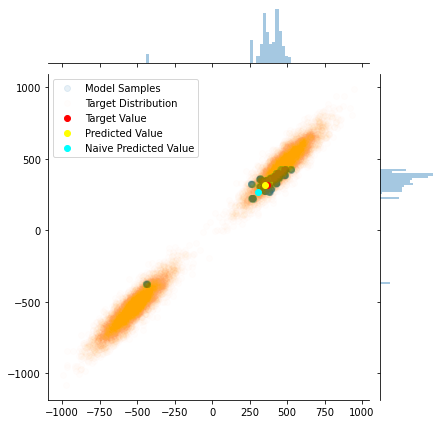

In [708]:
i += 5

alpha, beta, gamma = 1,1,1
samples = density_estimator1.sample(X_test[i:i+1], sample_size = 700, alpha = alpha, beta = beta, gamma = gamma, noise_factor = 0.1)
prediction = density_estimator1.custom_predict(
    X_test[i:i+1], agg_func = lambda x: np.mean(x,axis = 0), alpha = alpha, beta = beta, gamma = gamma)
naive_prediction = density_estimator1.predict(X_test[i:i+1])

if (len(samples.shape) > 1) and (samples.shape[-1] == 2):
    jntplot = sns.jointplot(samples[0,:,0], samples[0,:,1], joint_kws = {'label':'Model Samples', 'alpha':0.1})
    jntplot.ax_joint.scatter(y[:,0], y[:,1], color = 'orange', alpha = 0.01, label = 'Target Distribution')
    jntplot.ax_joint.scatter(y_test[i,0], y_test[i,1], color = 'red', label = 'Target Value')
    jntplot.ax_joint.scatter(prediction[0,0], prediction[0,1], color = 'yellow', label = 'Predicted Value')
    jntplot.ax_joint.scatter(naive_prediction[0,0], naive_prediction[0,1], color = 'cyan', label = 'Naive Predicted Value')
      
    jntplot.ax_joint.legend()

else:
    sns.distplot(samples, kde = True, bins = 20, hist_kws = {'label':'Model Samples'})
    dst = sns.distplot(y_test, kde = True, bins = 20, hist_kws = {'label':'Target Distribution'})
    dst._axes.axvline(y_test[i,1], color = 'r')
    dst._axes.legend()
    
    

In [709]:
alpha, beta, gamma = 1,1,1
samples1 = density_estimator1.sample(X_test, sample_size = 70, alpha = alpha, beta = beta, gamma = gamma)
kde_entropy(quantile(y_test,samples1)), bimodal_variance(samples1).mean()

(array([3.03886858]), 21931.158453374243)

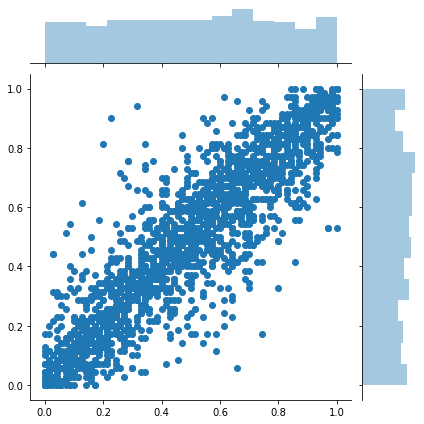

In [710]:
alpha, beta, gamma = 1,1,1
samples1 = density_estimator1.sample(X_test, sample_size = 70, alpha = alpha, beta = beta, gamma = gamma)
sns.jointplot(*quantile(y_test, samples1)[0].T)

## SimilarityEntropyTree- 
> A tree that predicts based on entropy-weighted query of representation vector (leaf nodes), good for mutlimodal data

two kinds of weights:
global node weight  = entropy of the node (y distribution)
node-sample weight = likelihood of y in the node distribution (kde, normal, lognormal, whatever)

node wieght -> multiplies column of one hot vectorized array after forest.apply
sample-node weight - > likelyhood of that point in that node

maybe node wieght doesnt make sense since a distribution with high entropy yields on low likelihoods

method 1:

set likelihood weights for each sample-node pair and define query space as a sparse wighted matrix.
then turing inference, query wieghted samples from query_space just like in sim tree.

method 2:

set distribution of each node, then during inference, draw samples from each node distribution. then, from all the sampled nodes, sample according to node entropy.

for peformance sake in inference time, user can define topn (sored by lowest entropy) explanatory nodes and sample from then according to their weights

set entropy threshold just to ensure only a few usefull nodes are reached.

user can define arbitrary prior distribution to nodes, although default is kde

#########################################################################################
appart from similarity factor $\alpha$, include node relevance factor $\beta$  in order to have $(\frac{NodeAggMetric}{NodeAggMetric_{max}})^\beta$ as node multipliers in the node - data adjacency matrix. NodeAggMetric could be variance, entropy, or user dfined metric, such as likelihood to some distribution.

then sample according to $CosSim(A,B)^\alpha$

May include KDE sampling for nodes, depending on ammount of nodes

make this framework default for every DensityTree (NaiveTree is a special case for alpha = 0 and beta = 0)

In [711]:
#export
class SimilarityTreeEnsembleEntropy(SimilarityTreeEnsemble):
    '''
    An ensemble that learn representitons of data turning target into bins
    '''
    def __init__(self, estimator, resolution = 2, **sim_tree_ensemble_init_args):
        super().__init__(estimator, **sim_tree_ensemble_init_args)
        self.resolution = resolution
    def fit(self, X, y = None):
        self.y_ = y
        #reshape (-1,1) in case of 1d
        y = _fix_X_1d(y)
        #make uniform quantile bins 
        self.quantizer = QuantileTransformer().fit(y)
        #transform to classes
        y = np.round(self.quantizer.transform(y), self.resolution).astype(str)
        # fit
        self.estimator.fit(X,y)
        self._fit_leaf_node_matrix(
            X, self.y_, node_rank_func = self.node_rank_func, node_data_rank_func = self.node_data_rank_func)# <- MAKE NODE WIEGHTED VERSION

        return self

In [712]:
#estimator2 = ensemble.GradientBoostingClassifier(n_estimators = 4,learning_rate = 0.05,min_samples_leaf = 5, subsample = 0.4, max_features = 0.4, verbose = 2,)
estimator2 = ensemble.RandomForestClassifier(n_jobs = -1,n_estimators = 30,min_samples_leaf = 5, warm_start = False, criterion = 'entropy')
#estimator1 = ensemble.RandomForestRegressor(n_jobs = -1,n_estimators = 10,min_samples_leaf = 5, warm_start = True, criterion = 'mae')

density_estimator2 = SimilarityTreeEnsembleEntropy(
    estimator2,node_rank_func = None, node_data_rank_func = None)

#density_estimator2 = JointOutputSimilarityTreeEstimator(density_estimator2)
density_estimator2.fit(X_train,y_train[:,:])

#density_estimator1 = SimilarityTreeEnsemble(
#    estimator1,node_rank_func = 'expected_likelihood', node_data_rank_func = 'kde_likelihood').fit(X_train,y_train[:,:])

SimilarityTreeEnsembleEntropy

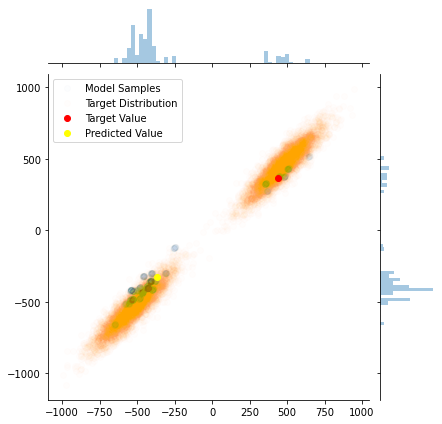

In [713]:
i += 1

alpha, beta, gamma = 1,1,0
samples = density_estimator2.kde_sample(X_test[i:i+1], sample_size = 700, alpha = alpha, beta = beta, gamma = gamma, bw = 'mean_distance')
#samples = density_estimator2.sample(X_test[i:i+1], sample_size = 700, alpha = alpha, beta = beta, gamma = gamma)
prediction = density_estimator2.custom_predict(X_test[i:i+1],agg_func = lambda x: np.mean(x, axis = 0) ,alpha = alpha, beta = beta, gamma = gamma)
#naive_prediction = density_estimator.estimator.predict(X_test[i:i+1])

if (len(samples.shape) > 1) and (samples.shape[-1] == 2):
    jntplot = sns.jointplot(samples[0,:,0], samples[0,:,1], joint_kws = {'label':'Model Samples', 'alpha':0.01})
    jntplot.ax_joint.scatter(y[:,0], y[:,1], color = 'orange', alpha = 0.01, label = 'Target Distribution')
    jntplot.ax_joint.scatter(y_test[i,0], y_test[i,1], color = 'red', label = 'Target Value')
    jntplot.ax_joint.scatter(prediction[0,0], prediction[0,1], color = 'yellow', label = 'Predicted Value')
    #jntplot.ax_joint.scatter(naive_prediction[0,0], naive_prediction[0,1], color = 'cyan', label = 'Naive Predicted Value')
      
    jntplot.ax_joint.legend()

else:
    sns.distplot(samples, kde = True, bins = 20, hist_kws = {'label':'Model Samples'})
    dst = sns.distplot(y_test, kde = True, bins = 20, hist_kws = {'label':'Target Distribution'})
    dst._axes.axvline(y_test[i,1], color = 'r')
    dst._axes.legend()

In [726]:
alpha, beta, gamma = 0.8,0.8,0
samples1 = density_estimator1.sample(X_test, sample_size = 299, alpha = alpha, beta = beta, gamma = gamma)
samples2 = density_estimator1.sample(X_test, sample_size = 299, alpha = alpha, beta = beta, gamma = gamma, noise_factor = 1)


We can plot the entropies of the distributions and the negative log likelihood of the generated KDE against de actual y_test value

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log2
  """Entry point for launching an IPython kernel.


-2.0984143357406118 -1.799753889840931


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log2
  


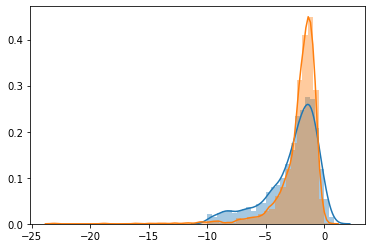

In [727]:
ll1 = np.log2(kde_likelihood(y_test,samples1))
ll2 = np.log2(kde_likelihood(y_test,samples2))
print(np.median(ll1[ll1 > -10]), np.median(ll2[ll2 > -10]))
sns.distplot(ll1[ll1 > -10])
sns.distplot(ll2[ll1 > -10])

1.953279044923092 2.478571894811619


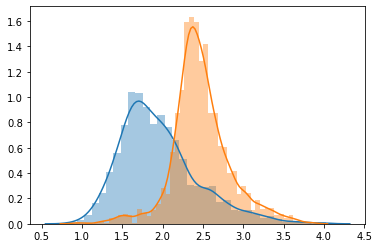

In [728]:
entr1 = kde_entropy(samples1, sample_size = 200)
entr2 = kde_entropy(samples2, sample_size = 200)
print(entr1.mean(),entr2.mean())
sns.distplot(entr1)
sns.distplot(entr2)

(1.1275799495499403, 1.6884423990278072)

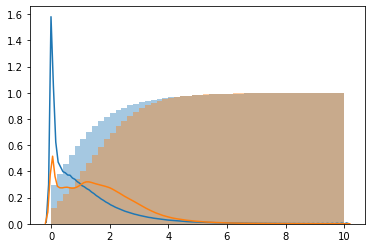

In [730]:
#we want the likelihood of our datapoints to be higher than the average likelihood of the distribution
# so we convert entropy and negative log likelihood  to likelihoods and divide the point likelihood by the average dist likeliihood
t1 = 2**ll1/2**-entr1
t2 = 2**ll2/2**-entr2
sns.distplot(t1[t1 < 10], hist_kws = dict(cumulative = True))
sns.distplot(t2[t2 < 10], hist_kws = dict(cumulative = True))
np.mean(t1[t1 < 1000]),np.mean(t2[t2 < 1000])

In [731]:
q2 = quantile(y_test,samples2)
q1 = quantile(y_test,samples1)

'3.68% of data points out of sugested boundaries'

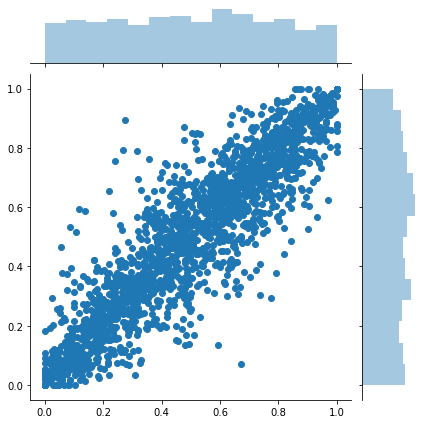

In [732]:
sns.jointplot(q1[0,:,0],q1[0,:,1])
f'{round(((q1 == 0).mean()+(q1 == 1).mean())*100,2)}% of data points out of sugested boundaries'

'1.0% of data points out of sugested boundaries'

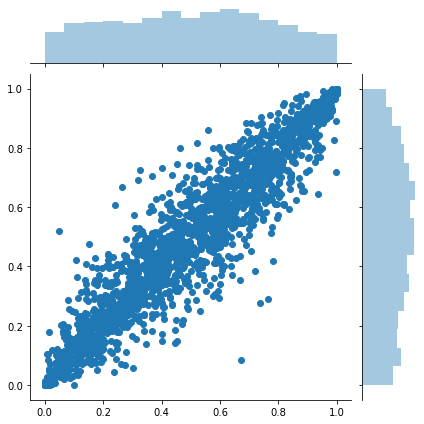

In [733]:
sns.jointplot(q2[0,:,0],q2[0,:,1])
f'{round(((q2 == 0).mean()+(q2 == 1).mean())*100,2)}% of data points out of sugested boundaries'

We can check the estimated KDE of the samples of each model against the y_test(target) distribution and the actual y_test value

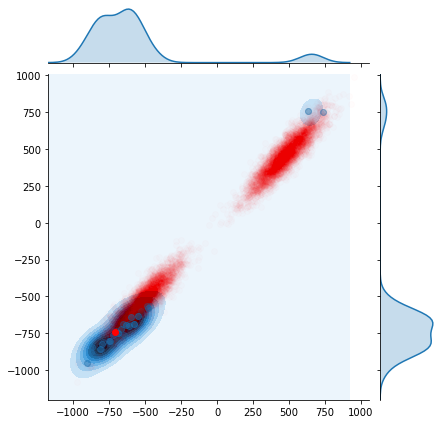

In [734]:
from sklearn.decomposition import PCA
i+=1
kde = KDE(implementation = 'sklearn').fit(samples1[i])
kde_cloud = kde.sample(100)
jnt = sns.jointplot(kde_cloud[:,0],kde_cloud[:,1], kind = 'kde')
jnt.ax_joint.scatter(density_estimator2.y_[:,0], density_estimator2.y_[:,1], color = 'r', alpha = 0.01)
jnt.ax_joint.scatter(samples1[i,:,0], samples1[i,:,1], alpha = 0.05)
jnt.ax_joint.scatter(y_test[i,0], y_test[i,1], color = 'r')

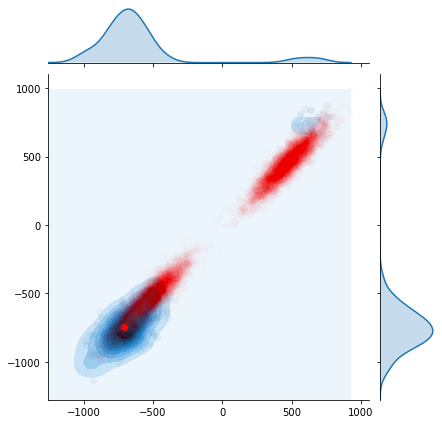

In [735]:
kde = KDE().fit(samples2[i])
kde_cloud = kde.sample(100)
jnt = sns.jointplot(kde_cloud[:,0],kde_cloud[:,1], kind = 'kde')
jnt.ax_joint.scatter(density_estimator2.y_[:,0], density_estimator2.y_[:,1], color = 'r', alpha = 0.01)
jnt.ax_joint.scatter(samples2[i,:,0], samples2[i,:,1], alpha = 0.05)
jnt.ax_joint.scatter(y_test[i,0], y_test[i,1], color = 'r')


# ConditionalMultimodalTest - 
> A multimodal test performed with datapoints close in a feature representation space in random forests

# Meta Estimators (Bagging, Boosting, Stacking)

## BaggingDensityEstimator

In [18]:
#export
def _parallel_predict_regression(estimators, estimators_features, X):
    """Private function used to compute predictions within a job."""
    return np.array([estimator.predict(X[:, features])
               for estimator, features in zip(estimators,
                                              estimators_features)])

class BaggingDensityEstimator(ensemble.BaggingRegressor):
    
    def sample(self, X, sample_size = 10, weights = None):
        idxs = self._sample_idxs(X, sample_size, weights)
        predictions = self._predict_all_estimators(X)
        return self._sample_from_idxs(predictions, idxs)        
        
    def _predict_all_estimators(self, X):    
        ensemble._bagging.check_is_fitted(self)
        # Check data
        X = ensemble._bagging.check_array(
            X, accept_sparse=['csr', 'csc'], dtype=None,
            force_all_finite=False
        )

        # Parallel loop
        n_jobs, n_estimators, starts = ensemble._bagging._partition_estimators(self.n_estimators,
                                                             self.n_jobs)

        all_y_hat = ensemble._bagging.Parallel(n_jobs=n_jobs, verbose=self.verbose)(
            ensemble._bagging.delayed(_parallel_predict_regression)(
                self.estimators_[starts[i]:starts[i + 1]],
                self.estimators_features_[starts[i]:starts[i + 1]],
                X)
            for i in range(n_jobs))

        predictions = np.swapaxes(all_y_hat[0], 0, 1)
        return predictions
    
    def _sample_from_idxs(self, predictions, idxs):        
        return np.array([predictions[i][idxs[i]] for i in range(len(idxs))])
    
    def _sample_idxs(self, X, sample_size, weights):
        '''Sample indxs according to estimator weights'''
        return [np.random.choice([*range(self.n_estimators)], size = sample_size, p = weights) for i in range(X.shape[0])]
            

The BaggingDensityEstimator is an extension of sklearn BaggingRegressor that allows sampling from each isntance of base estimator. We can bag Linear Regressors for example

In [19]:
from sklearn.linear_model import LinearRegression
estimator = LinearRegression()
density_estimator = BaggingDensityEstimator(estimator, n_estimators = 100, max_samples = 0.2, max_features = 0.2).fit(X,y)

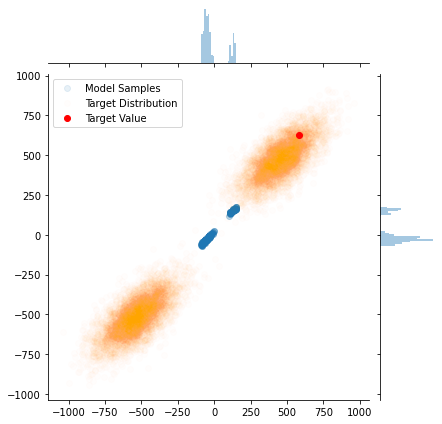

In [22]:
i = 5

samples = density_estimator.sample(X_test[i:i+1], sample_size = 700)

if (len(samples.shape) > 1) and (samples.shape[-1] == 2):
    jntplot = sns.jointplot(samples[0,:,0], samples[0,:,1], joint_kws = {'label':'Model Samples', 'alpha':0.1})
    jntplot.ax_joint.scatter(y[:,0], y[:,1], color = 'orange', alpha = 0.01, label = 'Target Distribution')
    jntplot.ax_joint.scatter(y_test[i,0], y_test[i,1], color = 'red', label = 'Target Value')
    #jntplot.ax_joint.scatter(prediction[0,0], prediction[0,1], color = 'yellow', label = 'Predicted Value')
    #jntplot.ax_joint.scatter(naive_prediction[0,0], naive_prediction[0,1], color = 'cyan', label = 'Naive Predicted Value')
      
    jntplot.ax_joint.legend()

else:
    sns.distplot(samples, kde = True, bins = 20, hist_kws = {'label':'Model Samples'})
    dst = sns.distplot(y_test, kde = True, bins = 20, hist_kws = {'label':'Target Distribution'})
    dst._axes.axvline(y_test[i,1], color = 'r')
    dst._axes.legend()
    
    

We can combine with the `BaggedClassifier` to make a bagged entropy model.

In [434]:
estimator = ensemble.BaggingClassifier(LogisticRegression())
density_estimator = EntropyEstimator(estimator = estimator, resolution = 100).fit(X_train,y_train[:,1])
#density_estimator = BaggingDensityEstimator(estimator, n_estimators = 10, max_samples = 0.3,max_features = 0.3, bootstrap_features = True).fit(X_train,y_train[:,1])

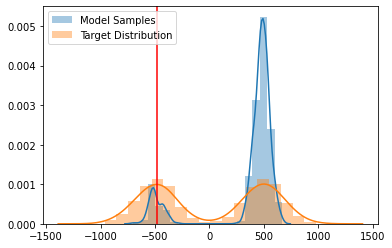

In [435]:
i = 5

samples = density_estimator.sample(X_test[i:i+1], sample_size = 700)

if (len(samples.shape) > 1) and (samples.shape[-1] == 2):
    jntplot = sns.jointplot(samples[0,:,0], samples[0,:,1], joint_kws = {'label':'Model Samples', 'alpha':0.1})
    jntplot.ax_joint.scatter(y[:,0], y[:,1], color = 'orange', alpha = 0.01, label = 'Target Distribution')
    jntplot.ax_joint.scatter(y_test[i,0], y_test[i,1], color = 'red', label = 'Target Value')
    jntplot.ax_joint.scatter(prediction[0,0], prediction[0,1], color = 'yellow', label = 'Predicted Value')
    jntplot.ax_joint.scatter(naive_prediction[0,0], naive_prediction[0,1], color = 'cyan', label = 'Naive Predicted Value')
      
    jntplot.ax_joint.legend()

else:
    sns.distplot(samples, kde = True, bins = 20, hist_kws = {'label':'Model Samples'})
    dst = sns.distplot(y_test, kde = True, bins = 20, hist_kws = {'label':'Target Distribution'})
    dst._axes.axvline(y_test[i,1], color = 'r')
    dst._axes.legend()
    
    

## AdaBoostDensityEstimator

In [797]:
#export
class AdaBoostDensityEntropyEstimator:
    pass

class AdaBoostDensityEstiamtor(ensemble.AdaBoostRegressor):
    
    def sample(self, X, sample_size = 10, weights = 'boosting_weights'):
        idxs = self._sample_idxs(X, sample_size, weights)
        predictions = self._predict_all_estimators(X)
        return self._sample_from_idxs(predictions, idxs)
    
    def _predict_all_estimators(self, X):    
        return np.array([est.predict(X) for est in self.estimators_[:len(self.estimators_)]]).T
    
    def _sample_from_idxs(self, predictions, idxs):
        return np.array([predictions[i][idxs[i]] for i in range(len(idxs))])
    
    def _sample_idxs(self, X, sample_size, weights):
        '''Sample indxs according to estimator weights'''        
                        
        if weights is None:
            weights = np.ones(sample_size)[:len(self.estimators_)]
            weights /= weights.sum()
            
        elif weights == 'boosting_weights':
            weights = self.estimator_weights_[:len(self.estimators_)]
            weights /= weights.sum()            
        else:
            weights = self.estimator_weights_[:len(self.estimators_)]*weights
            weights /= weights.sum()        
            
        idxs = [np.random.choice([*range(len(self.estimators_))], size = sample_size, p = weights) for i in range(X.shape[0])]
        return idxs
        
        

AdaBoostDensityEstimator suports only single output tasks. you can use `JoinOutputRegressor`, but since it will fit each output dimension separetly, you have a decent prediction for the marginal distributions but not for the joint distribution.

For this reason, AdaBoostEstimator is not recomended for multivariate density estimation

In [798]:
from sklearn.tree import DecisionTreeRegressor
estimator = AdaBoostDensityEstiamtor(TransformedTargetRegressor(DecisionTreeRegressor(),QuantileTransformer()), learning_rate = 0.1, n_estimators = 5)
multioutput_estimator = JointEstimator(estimator)
density_estimator = multioutput_estimator.fit(X_train, y_train)

C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass transformer=QuantileTransformer() as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


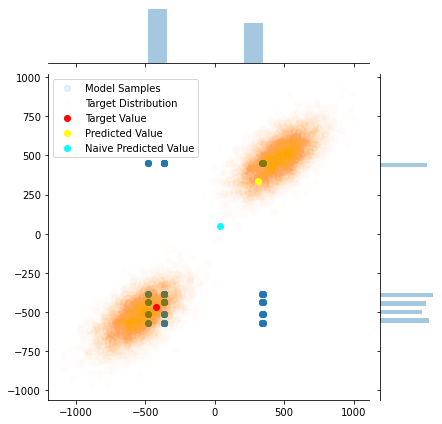

In [799]:
i = 5

samples = density_estimator.sample(X_test[i:i+1], sample_size = 700)

if (len(samples.shape) > 1) and (samples.shape[-1] == 2):
    jntplot = sns.jointplot(samples[0,:,0], samples[0,:,1], joint_kws = {'label':'Model Samples', 'alpha':0.1})
    jntplot.ax_joint.scatter(y[:,0], y[:,1], color = 'orange', alpha = 0.01, label = 'Target Distribution')
    jntplot.ax_joint.scatter(y_test[i,0], y_test[i,1], color = 'red', label = 'Target Value')
    jntplot.ax_joint.scatter(prediction[0,0], prediction[0,1], color = 'yellow', label = 'Predicted Value')
    jntplot.ax_joint.scatter(naive_prediction[0,0], naive_prediction[0,1], color = 'cyan', label = 'Naive Predicted Value')
      
    jntplot.ax_joint.legend()

else:
    sns.distplot(samples, kde = True, bins = 20, hist_kws = {'label':'Model Samples'})
    dst = sns.distplot(y_test, kde = True, bins = 20, hist_kws = {'label':'Target Distribution'})
    dst._axes.axvline(y_test[i,1], color = 'r')
    dst._axes.legend()
    
    

We can see that for 1d estimation it works quite well

In [800]:
import matplotlib.pyplot as plt
estimator = DecisionTreeRegressor()
density_estimator = AdaBoostDensityEstiamtor(estimator, learning_rate = 0.1).fit(X_train, y_train[:,0])

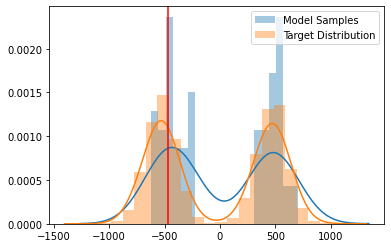

In [801]:
i = 5

samples = density_estimator.sample(X_test[i:i+1], sample_size = 70)

if (len(samples.shape) > 1) and (samples.shape[-1] == 2):
    jntplot = sns.jointplot(samples[0,:,0], samples[0,:,1], joint_kws = {'label':'Model Samples', 'alpha':0.1})
    jntplot.ax_joint.scatter(y[:,0], y[:,1], color = 'orange', alpha = 0.01, label = 'Target Distribution')
    jntplot.ax_joint.scatter(y_test[i,0], y_test[i,1], color = 'red', label = 'Target Value')
    jntplot.ax_joint.scatter(prediction[0,0], prediction[0,1], color = 'yellow', label = 'Predicted Value')
    jntplot.ax_joint.scatter(naive_prediction[0,0], naive_prediction[0,1], color = 'cyan', label = 'Naive Predicted Value')
      
    jntplot.ax_joint.legend()

else:
    sns.distplot(samples, kde = True, bins = 20, hist_kws = {'label':'Model Samples'})
    dst = sns.distplot(y_test, kde = True, bins = 20, hist_kws = {'label':'Target Distribution'})
    dst._axes.axvline(y_test[i,1], color = 'r')
    dst._axes.legend()
    
    

## StackingDensityEstimator
> Allows for stacking while making the input of last layer as a sample of last estimators samples

# Export -

In [27]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_core.ipynb.
Converted 01_ensemble.ipynb.
Converted 02_core.random_variable.ipynb.
Converted 03_utils.ipynb.
Converted 04_metrics.ipynb.
Converted 05_neighbors.ipynb.
Converted 06_kde_baesyan_nets.ipynb.
Converted index.ipynb.
